# Clasificacion Automatica de Tickets con NLP

### Integrantes
* Walter Manuel Marañon Quiñones
* Patricia Mollericona Bautista
* Jorge Reynaldo Vallejos Escobar

## Descripcion del Problema

Debe crear un modelo que pueda clasificar las quejas (complaints) de los clientes en función de los productos/servicios. Al hacerlo, puede segregar estos tickets en sus categorías relevantes y, por lo tanto, ayudar en la resolución rápida del problema.

Realizará el modelado de temas en los datos <b>.json</b> proporcionados por la empresa. Dado que estos datos no están etiquetados, debe aplicar NMF para analizar patrones y clasificar los tickets en los siguientes cinco grupos según sus productos/servicios:

* Tarjetas de Credito / Tarjetas Prepagadas (Credit card / Prepaid Card)

* Servicios de Cuentas de Banco (Bank account services)

* Reportes de Robos (Theft/Dispute reporting)

* Prestamos Hipotecarios y Otros Prestamos (Mortgages/loans)

* Otros

Con la ayuda del modelado de temas, podrá asignar cada ticket a su respectivo departamento/categoría. Luego puede usar estos datos para entrenar cualquier modelo supervisado, como regresión logística, árbol de decisión o bosque aleatorio. Usando este modelo entrenado, puede clasificar cualquier nuevo ticket de soporte de quejas de clientes en su departamento correspondiente.

## Flujo de Trajajo a Realizar:

Debe realizar las siguientes ocho tareas principales para completar la tarea:

1. Data Loading

2. Text preprocessing

3. Exploratory Data Analysis (EDA)

4. Feature Extraction

5. Topic modeling

6. Model building using Supervised Learning

7. Model training and evaluation

8. Model inference

## Setup e Importacion de Librerias

In [1]:
## SpaCy and en_core_web_sm installation
!pip install spacy

##run the following command in the console
#python -m spacy download en_core_web_sm

In [2]:
!pip install pycaret

## Importing the necessary libraries

In [3]:
import json
import numpy as np
import pandas as pd
import re, string

# Import NLTK libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import Spacy libraries
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from pprint import pprint

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

from pandas import json_normalize
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.model_selection import train_test_split
from pycaret.classification import setup, compare_models, create_model, plot_model, evaluate_model, finalize_model, predict_model


In [4]:
#import nltk

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Loading the data

Los datos están en formato JSON y necesitamos convertirlos a un dataframe.

In [5]:
jsonData = pd.read_json('complaints.json')
jsonData.head()

,_index,_type,_id,_score,_source
0,complaint-public-v2,complaint,3211475,0,"{'tags': None, 'zip_code': '90301', 'complaint..."
1,complaint-public-v2,complaint,3229299,0,"{'tags': 'Servicemember', 'zip_code': '319XX',..."
2,complaint-public-v2,complaint,3199379,0,"{'tags': None, 'zip_code': '77069', 'complaint..."
3,complaint-public-v2,complaint,2673060,0,"{'tags': None, 'zip_code': '48066', 'complaint..."
4,complaint-public-v2,complaint,3203545,0,"{'tags': None, 'zip_code': '10473', 'complaint..."


## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.
print("Tamaño del DataSet (json file)",jsonData.shape)
jsonData.info()

Tamaño del DataSet (json file) (78313, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   _index   78313 non-null  object
 1   _type    78313 non-null  object
 2   _id      78313 non-null  int64 
 3   _score   78313 non-null  int64 
 4   _source  78313 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.0+ MB


In [7]:
#Creamos un nuevo dataset para guardar los datos de la columna Source

SourceData = json_normalize(jsonData["_source"])
print("Tamaño del DataSet (Source)",SourceData.shape)

SourceData.head()

Tamaño del DataSet (Source) (78313, 18)


,tags,zip_code,complaint_id,issue,date_received,state,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
#print the column names

print(SourceData.columns)

Index(['tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state',
       'consumer_disputed', 'product', 'company_response', 'company',
       'submitted_via', 'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely', 'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided'],
      dtype='object')


In [9]:
SourceData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   tags                       10900 non-null  object
 1   zip_code                   71556 non-null  object
 2   complaint_id               78313 non-null  object
 3   issue                      78313 non-null  object
 4   date_received              78313 non-null  object
 5   state                      76322 non-null  object
 6   consumer_disputed          78313 non-null  object
 7   product                    78313 non-null  object
 8   company_response           78313 non-null  object
 9   company                    78313 non-null  object
 10  submitted_via              78313 non-null  object
 11  date_sent_to_company       78313 non-null  object
 12  company_public_response    4 non-null      object
 13  sub_product                67742 non-null  object
 14  timely

In [10]:
#Assign new column names

SourceData.rename(columns={'company_public_response': 'public_response'}, inplace=True)
SourceData.rename(columns={'complaint_what_happened': 'complaint_details'}, inplace=True)
SourceData.rename(columns={'consumer_consent_provided': 'consumer_consent'}, inplace=True)

#SourceData.info()

In [11]:
#Assign nan in place of blanks in the complaints column
SourceData = SourceData.replace('', np.nan)
#SourceData.head(2)

In [12]:
counter = SourceData.isnull().sum()
percentage_nans = round(counter / SourceData.shape[0] * 100, 2)
nan_data = pd.concat([counter, percentage_nans], axis=1).reset_index()
nan_data.columns = ['Columns', 'Total', 'nan_Percentage']
nan_data.sort_values(by='nan_Percentage', ascending=False, inplace=True)
nan_data.reset_index(drop=True, inplace=True)
nan_data

,Columns,Total,nan_Percentage
0,public_response,78309,99.99
1,tags,67413,86.08
2,complaint_details,57241,73.09
3,sub_issue,46297,59.12
4,sub_product,10571,13.50
5,zip_code,6757,8.63
6,state,1991,2.54
7,consumer_consent,1008,1.29
8,company_response,0,0.00
9,product,0,0.00


In [13]:
#Remove all rows where complaints column is nan

SourceData.dropna(subset=['complaint_details'], inplace=True)

print("Nueva dimensión: ",SourceData.shape)
SourceData.reset_index(drop=True, inplace=True)

Nueva dimensión:  (21072, 18)


In [14]:
#SourceData.info()

## Prepare the text for topic modeling

Una vez que haya eliminado todas las quejas en blanco, debe:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers

Una vez que haya realizado estas operaciones de limpieza, debe realizar lo siguiente:

* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    # 1. Convert text to lowercase
    text = text.lower()

    # 2. Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)

    # 3. Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # 4. Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)

    return text

In [16]:
# Write your function to Lemmatize the texts
def lemmatize_text(text):
    # Lemmatize and keep only nouns (NN)
    doc = nlp(text)

    # Extract lemmas for all tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    # Join tokens back into a single string
    return " ".join(lemmatized_tokens)

In [17]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
# it could take ~15 min

df_clean = pd.DataFrame()
df_clean['complaint'] = SourceData['complaint_details'].apply(preprocess_text)
df_clean['complaint_lemmatized'] = df_clean['complaint'].apply(lemmatize_text)

In [18]:
df_clean.head(5)

,complaint,complaint_lemmatized
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


In [19]:
#Write your function to extract the POS tags

# Function to process text and retain only nouns
def pos_tag(text):
    # Apply SpaCy NLP pipeline
    doc = nlp(text)
    # Extract lemmas of tokens with POS tag 'NOUN'
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    # Return the processed text
    return " ".join(nouns)

df_clean["complaint_POS_removed"] =  df_clean['complaint_lemmatized'].apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [20]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(5)

,complaint,complaint_lemmatized,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...


## Exploratory data analysis to get familiar with the data.

Escriba el código en esta tarea para realizar lo siguiente:

* Visualiza los datos según la longitud del carácteres 'Complaint'
* Usando una nube de palabras, encuentre las top 40 palabras más frecuentes de todos los artículos después de procesar el texto
* Encuentre los mejores unigramas, bigramas y trigramas por frecuencia entre todas las quejas después de procesar el texto. '

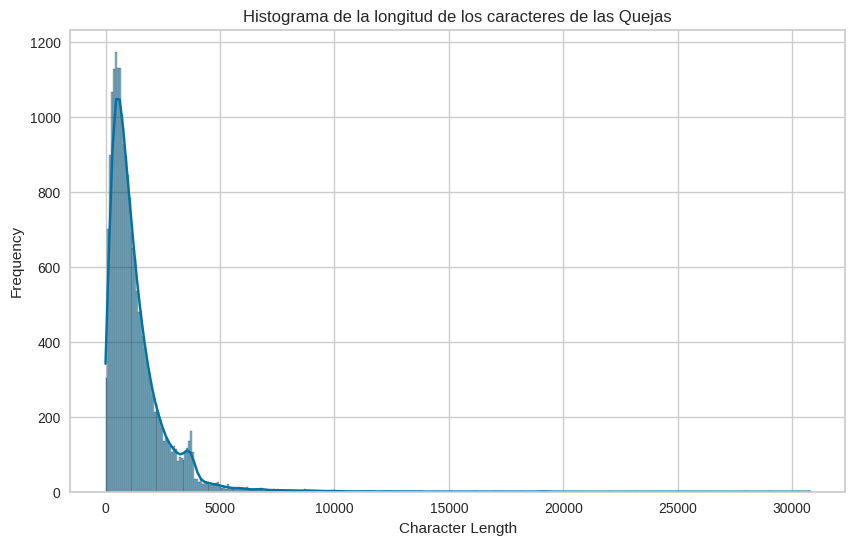

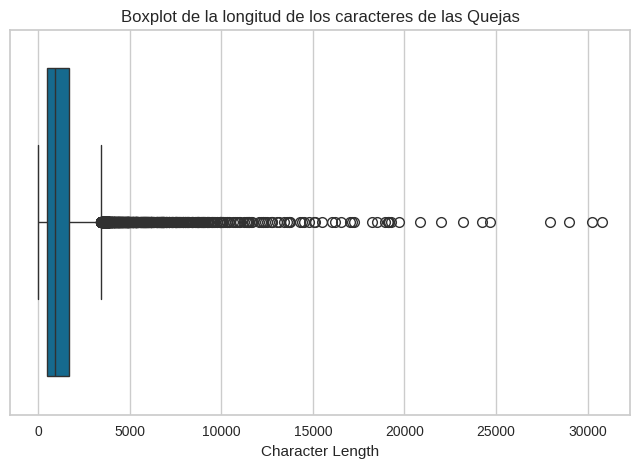

In [23]:
# Write your code here to visualise the data according to the 'Complaint' character length

# Step 1: Calculate character length of each complaint
df_clean["complaint_length"] = df_clean["complaint"].apply(len)

# Step 2: Visualization - Histogram
plt.figure(figsize=(10, 6))
#sns.histplot(df_clean["complaint_length"], bins=10, kde=True, color='blue')
sns.histplot(df_clean["complaint_length"],  kde=True)
plt.title("Histograma de la longitud de los caracteres de las Quejas")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

# Step 3: Visualization - Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_clean["complaint_length"])
plt.title("Boxplot de la longitud de los caracteres de las Quejas")
plt.xlabel("Character Length")
plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

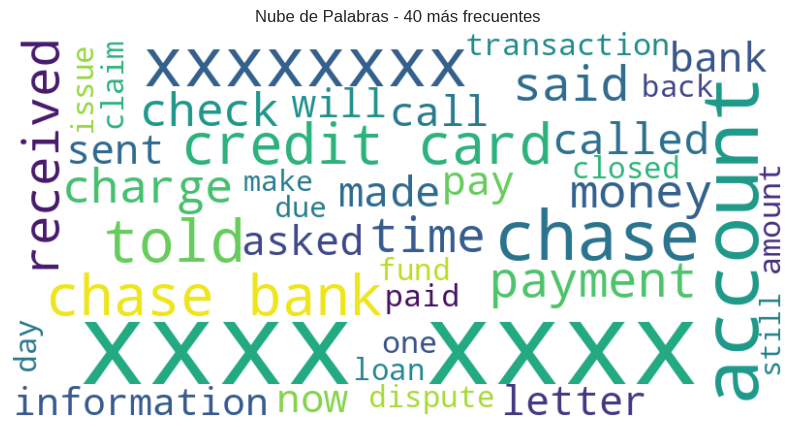

In [24]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud

all_text = " ".join(df_clean["complaint"])
wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=40, colormap="viridis").generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de Palabras - 40 más frecuentes")
plt.show()

In [25]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [26]:
df_clean.head()

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,475,morning name stop bank service ask debt verifi...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,337,xxxx card agent anniversary date agent informa...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,210,chase card report application identity consent...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,1433,xxxx xxxx ticket offer ticket reward card info...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [27]:
def plot_ngram_frequencies(ngram_freqs, title, top_n=10):
    # Extraer las palabras y sus frecuencias
    ngrams, freqs = zip(*ngram_freqs[:top_n])

    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    sns.barplot(x=freqs, y=ngrams, palette="viridis")
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("N-grama")
    plt.show()

In [28]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
from sklearn.feature_extraction.text import CountVectorizer

def generate_ngrams(texts, n=1, top_n=30):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    X = vectorizer.fit_transform(texts)
    freqs = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0])
    sorted_ngrams = sorted(freqs, key=lambda x: x[1], reverse=True)[:top_n]
    return sorted_ngrams

# Unigramas
top_unigrams = generate_ngrams(df_clean["Complaint_clean"], top_n=30)
print("Top 30 Unigramas:", top_unigrams)


Top 30 Unigramas: [('chase', 52742), ('xxxx', 48288), ('account', 46731), ('credit', 33470), ('card', 30216), ('bank', 21612), ('payment', 21158), ('time', 16011), ('charge', 14152), ('xxxxxxxx', 13581), ('day', 12971), ('check', 12099), ('money', 11953), ('loan', 10900), ('information', 9644), ('letter', 9598), ('fee', 8890), ('report', 8855), ('number', 8614), ('transaction', 8564), ('month', 8461), ('year', 8289), ('customer', 8137), ('mortgage', 8072), ('balance', 7759), ('service', 7698), ('phone', 7570), ('company', 7536), ('claim', 7211), ('state', 7152)]


Top 10 Unigrams:
[('chase', 52742), ('xxxx', 48288), ('account', 46731), ('credit', 33470), ('card', 30216), ('bank', 21612), ('payment', 21158), ('time', 16011), ('charge', 14152), ('xxxxxxxx', 13581)]




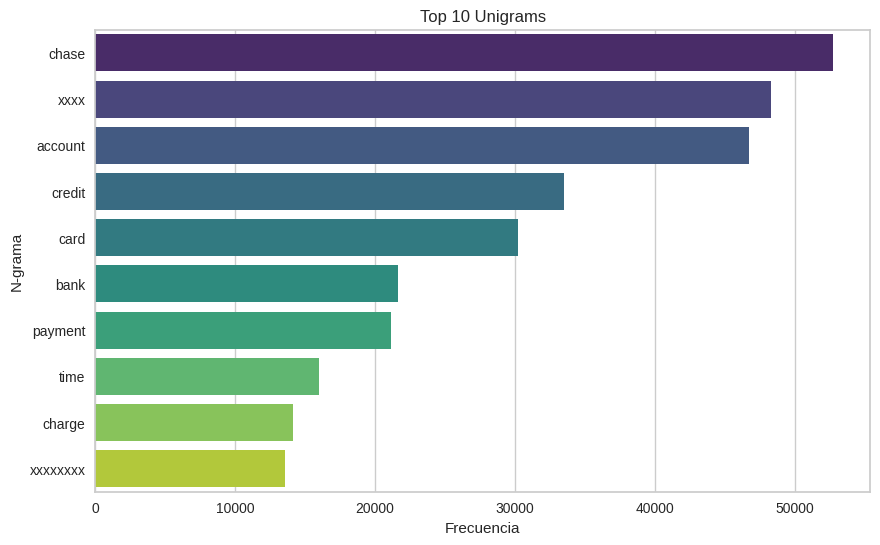

In [29]:
#Print the top 10 words in the unigram frequency
print("Top 10 Unigrams:")
print(top_unigrams[:10])

print("\n")
plot_ngram_frequencies(top_unigrams, "Top 10 Unigrams")

In [30]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).

# Bigramas
top_bigrams = generate_ngrams(df_clean["Complaint_clean"], n=2, top_n=30)
print("Top 30 Bigramas:", top_bigrams)

Top 30 Bigramas: [('credit card', 12850), ('xxxx xxxx', 5229), ('credit report', 3930), ('customer service', 3058), ('account chase', 2930), ('chase credit', 2822), ('chase account', 2597), ('bank account', 2440), ('check account', 2289), ('account account', 2249), ('chase bank', 2078), ('debit card', 1965), ('checking account', 1848), ('account xxxx', 1833), ('chase card', 1751), ('credit score', 1707), ('xxxx chase', 1693), ('xxxx credit', 1673), ('number xxxx', 1670), ('card account', 1668), ('card chase', 1549), ('xxxx account', 1475), ('account credit', 1447), ('chase xxxx', 1361), ('account bank', 1289), ('money account', 1277), ('phone number', 1257), ('business day', 1253), ('payment payment', 1229), ('xxxx payment', 1145)]



Top 10 Bigrams:
[('credit card', 12850), ('xxxx xxxx', 5229), ('credit report', 3930), ('customer service', 3058), ('account chase', 2930), ('chase credit', 2822), ('chase account', 2597), ('bank account', 2440), ('check account', 2289), ('account account', 2249)]




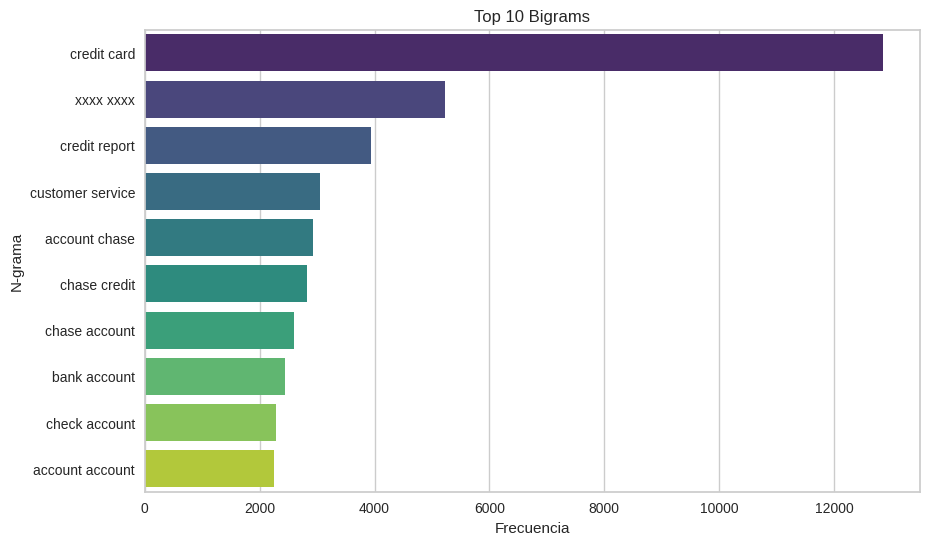

In [31]:
#Print the top 10 words in the bigram frequency

print("\nTop 10 Bigrams:")
print(top_bigrams[:10])

print("\n")
plot_ngram_frequencies(top_bigrams, "Top 10 Bigrams")

In [32]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).

# Trigramas
top_trigrams = generate_ngrams(df_clean["Complaint_clean"], n=3, top_n=30)
print("Top 30 Trigramas:", top_trigrams)

Top 30 Trigramas: [('chase credit card', 1890), ('credit card account', 1088), ('credit card company', 988), ('xxxx xxxx xxxx', 842), ('xxxx credit card', 812), ('credit card chase', 710), ('credit card credit', 512), ('inquiry credit report', 489), ('credit card xxxx', 430), ('account credit card', 410), ('chase customer service', 392), ('charge credit card', 389), ('card credit card', 382), ('credit reporting agency', 382), ('chase checking account', 373), ('credit report credit', 353), ('customer service representative', 339), ('credit reporting act', 338), ('credit card payment', 310), ('credit card charge', 288), ('chase bank account', 280), ('account chase account', 276), ('account credit report', 273), ('account number xxxx', 271), ('bank credit card', 262), ('credit card balance', 257), ('chase card service', 255), ('chase auto finance', 253), ('victim identity theft', 251), ('credit card card', 248)]



Top 10 Trigrams:
[('chase credit card', 1890), ('credit card account', 1088), ('credit card company', 988), ('xxxx xxxx xxxx', 842), ('xxxx credit card', 812), ('credit card chase', 710), ('credit card credit', 512), ('inquiry credit report', 489), ('credit card xxxx', 430), ('account credit card', 410)]




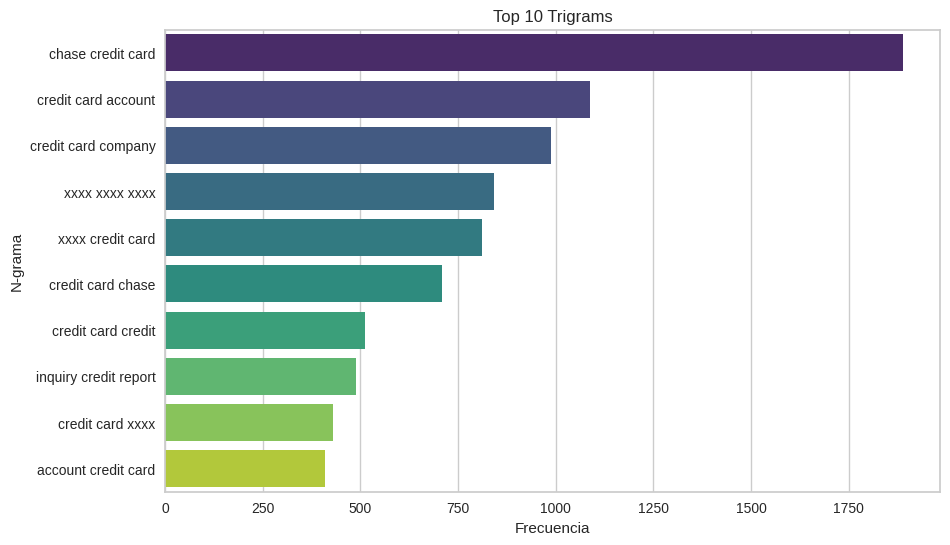

In [33]:
#Print the top 10 words in the trigram frequency

print("\nTop 10 Trigrams:")
print(top_trigrams[:10])

print("\n")
plot_ngram_frequencies(top_trigrams, "Top 10 Trigrams")

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [34]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [35]:
#All masked texts has been removed
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,475,morning name stop bank service ask debt verifi...
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,337,card agent anniversary date agent information...
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,210,chase card report application identity consent...
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,1433,ticket offer ticket reward card information ...
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...
...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,650,chase card customer decade solicitation credit...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,2067,credit card provider claim purchase protectio...
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,2296,risk consumer chase bank app chase year banki...
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,2009,credit yrs chase credit card chase freedom pro...


## Feature Extraction
Convierta los textos sin procesar en una matriz de características TF-IDF

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [38]:
# Write your code here to initialise the TfidfVectorizer

#vectorizer = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.95)
vectorizer = TfidfVectorizer(stop_words='english', min_df=10, max_df=0.80)
tfidf_vectors = vectorizer.fit_transform(df_clean['complaint'])

In [39]:
import pickle

# Save the vectorizer to a file
with open('saved_vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)

print("Vectorizer saved successfully.")

Vectorizer saved successfully.


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [40]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_vectors = normalize(tfidf_vectors, norm='l2', axis=1)

df_matrix = pd.DataFrame(tfidf_vectors.toarray(), columns=vectorizer.get_feature_names_out())
df_matrix.head()

,aarp,abandoned,abide,abiding,abilities,ability,able,abovereferenced,abroad,abrupt,...,youll,young,younger,youre,youve,yr,yrs,zero,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) es una técnica no supervisada, por lo que no hay etiquetas de temas en los que se entrenará el modelo. La forma en que funciona es que NMF descompone (o factoriza) vectores de alta dimensión en una representación de menor dimensión. Estos vectores de menor dimensión no son negativos, lo que también significa que sus coeficientes no son negativos.

En esta tarea tienes que realizar lo siguiente:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

* Encuentra el mejor número de clústeres
* Aplicar el mejor número para crear grupos de palabras
* Inspeccionar y validar la corrección de cada grupo frente a las quejas (Complaints)
* Corrija las etiquetas si es necesario
* Mapear el grupo de nombres de topicos/clusters

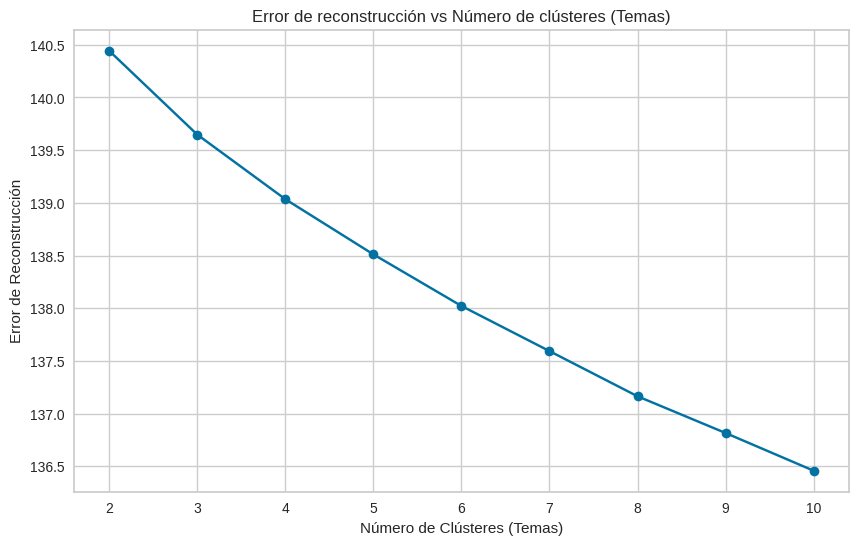

In [41]:
from sklearn.decomposition import NMF

# Función para probar diferentes números de temas
def find_best_nmf_clusters(tfidf_vectors, max_topics=10):
    reconstruction_errors = []
    for n in range(2, max_topics + 1):
        nmf_model = NMF(n_components=n, random_state=42)
        nmf_model.fit(tfidf_vectors)
        reconstruction_errors.append(nmf_model.reconstruction_err_)

    # Graficar los errores de reconstrucción para identificar el mejor número de clústeres
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_topics + 1), reconstruction_errors, marker='o')
    plt.title('Error de reconstrucción vs Número de clústeres (Temas)')
    plt.xlabel('Número de Clústeres (Temas)')
    plt.ylabel('Error de Reconstrucción')
    plt.show()

    return reconstruction_errors

# Determinar el mejor número de clústeres para los datos TF-IDF
reconstruction_errors = find_best_nmf_clusters(tfidf_vectors, max_topics=10)

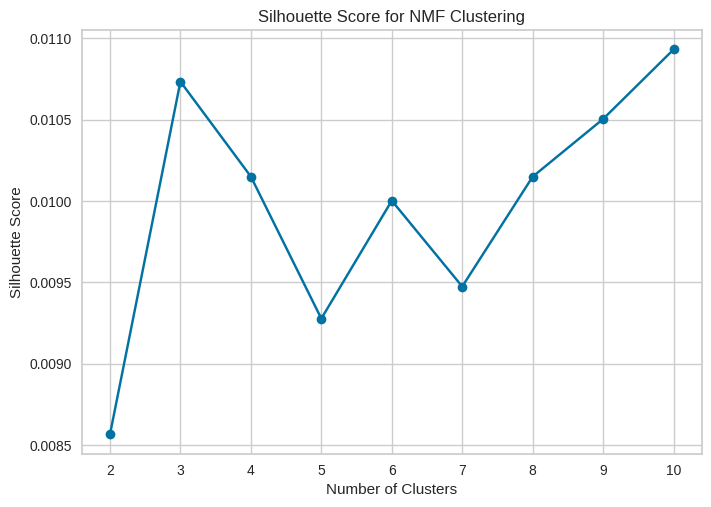

In [42]:
from sklearn.metrics import silhouette_score

cluster_range = range(2, 11)
silhouette_scores = []

for n_clusters in cluster_range:
    nmf = NMF(n_components=n_clusters)
    nmf.fit(tfidf_vectors)  # Replace with your data
    cluster_labels = nmf.transform(tfidf_vectors).argmax(axis=1)
    silhouette_avg = silhouette_score(tfidf_vectors, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for NMF Clustering')
plt.show()

In [43]:
# Mejor número de clústeres encontrado manualmente o desde los errores de reconstrucción
best_n_clusters = 10  # elvalor se encontro por medio del grafico anterior

# Crear y ajustar el modelo NMF con el mejor número de clústeres
nmf_model = NMF(n_components=best_n_clusters, random_state=42)
nmf_model.fit(tfidf_vectors)

# Matriz de palabras por clúster (H)
word_clusters = nmf_model.components_

# Obtener las palabras clave por tema
feature_names = vectorizer.get_feature_names_out()

def display_topics(word_clusters, feature_names, top_words=10):
    for i, topic in enumerate(word_clusters):
        print(f"Clúster {i}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
        print("\n")

# Mostrar las palabras clave por clúster
display_topics(word_clusters, feature_names)

Clúster 0:
account, closed, checking, accounts, opened, bank, open, close, savings, funds


Clúster 1:
card, credit, cards, applied, points, limit, score, offer, closed, used


Clúster 2:
loan, mortgage, modification, home, property, foreclosure, payments, years, rate, jp


Clúster 3:
xxxxxxxx, letter, received, date, called, email, statement, dated, told, sent


Clúster 4:
credit, report, inquiry, hard, inquiries, reporting, jpmcb, removed, debt, information


Clúster 5:
payment, late, payments, month, paid, pay, credit, auto, make, days


Clúster 6:
check, funds, deposited, deposit, bank, checks, cashed, cleared, hold, cash


Clúster 7:
charges, dispute, charge, merchant, fraud, fraudulent, claim, transaction, received, company


Clúster 8:
balance, fee, fees, charged, overdraft, paid, charge, pay, annual, transfer


Clúster 9:
money, bank, told, said, called, number, did, asked, phone, nt




## **Descripcion de las etiquetas para asignar a cada clúster**

* Clúster 0: "Bank Accounts"
 Este clúster se centra en cuentas bancarias, tanto de cheques como de ahorros, incluyendo temas relacionados con la apertura y cierre de cuentas.

* Clúster 1: "Credit Cards"
 Las palabras clave indican problemas relacionados con tarjetas de crédito, límites, aplicaciones y cierres de cuentas de tarjetas.

* Clúster 2: "Loans and Mortgages"
 Enfocado en préstamos, hipotecas, modificaciones, tasas de interés y ejecución hipotecaria.

* Clúster 3: "Correspondence and Communication"
 Este clúster parece estar relacionado con la correspondencia (cartas, correos electrónicos) y llamadas telefónicas. Puede implicar problemas de comunicación o documentación.

* Clúster 4: "Credit Reports and Inquiries"
 Relacionado con reportes de crédito, consultas, deudas y problemas de información en informes crediticios.

* Clúster 5: "Payments and Delays"
 Se enfoca en pagos atrasados, meses sin pago, pagos automáticos y problemas relacionados con pagos en general.

* Clúster 6: "Checks and Deposits"
 Trata problemas con cheques, depósitos, fondos retenidos y procesamiento de transacciones.

* Clúster 7: "Disputes and Fraud"
 Incluye disputas de cargos, transacciones fraudulentas, y reclamaciones de fraude.

* Clúster 8: "Fees and Charges"
 Se centra en comisiones, cargos por sobregiros, transferencias y cuotas anuales.

* Clúster 9: "General Transactions and Customer Service"
 Este clúster parece ser más general, con palabras relacionadas con llamadas, números y transacciones.

In [44]:
#
topic_probabilities = nmf_model.transform(tfidf_vectors)

# Asignar el tema más probable para cada documento
df_clean['topic'] = topic_probabilities.argmax(axis=1)

# Asignar clústeres a las etiquetas de temas
topic_names = {
    0: "Bank Accounts",
    1: "Credit Cards",
    2: "Loans and Mortgages",
    3: "Correspondence and Communication",
    4: "Credit Reports and Inquiries",
    5: "Payments and Delays",
    6: "Checks and Deposits",
    7: "Disputes and Fraud",
    8: "Fees and Charges",
    9: "General Transactions and Customer Service"
}

# Agregar los topic labels al dataFrame
df_clean['topic_label'] = df_clean['topic'].map(topic_names)

# Mostrar los complaints por cada topic
for topic_id, topic_label in topic_names.items():
    print(f"\nExamples for topic '{topic_label}':")
    print(df_clean[df_clean['topic'] == topic_id]['complaint'].head(3))


Examples for topic 'Bank Accounts':
6     with out notice jp morgan chase restricted my ...
10    mishandling of this account by chase auto and ...
12    i opened an account with chase bank on xxxx an...
Name: complaint, dtype: object

Examples for topic 'Credit Cards':
2     chase card was reported on  however fraudulent...
3     on  while trying to book a xxxx  xxxx  ticket ...
14    my chase amazon card was declined for a cateri...
Name: complaint, dtype: object

Examples for topic 'Loans and Mortgages':
23    i have been trying to do a loan modification w...
30    i have wired through one of chase branches in ...
32    i bought a new xxxx xxxx on xxxxxxxx from xxxx...
Name: complaint, dtype: object

Examples for topic 'Correspondence and Communication':
1     i upgraded my xxxx xxxx card in  and was told ...
20    jp morgan chase bank please answer the followi...
22    my roommate was stealing my chase debit card a...
Name: complaint, dtype: object

Examples for topic 'Credit Repo

In [45]:
df_clean.head()

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,topic,topic_label
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,475,morning name stop bank service ask debt verifi...,9,General Transactions and Customer Service
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,337,card agent anniversary date agent information...,3,Correspondence and Communication
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,210,chase card report application identity consent...,1,Credit Cards
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,1433,ticket offer ticket reward card information ...,1,Credit Cards
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,6,Checks and Deposits


## Manual Topic Modeling
Debe adoptar el enfoque de prueba y error para encontrar la mejor cantidad de topicos para su modelo NMF.

El único parámetro que se requiere es el número de componentes, es decir, el número de topicos que queremos. Este es el paso más crucial en todo el proceso de modelado de topicos y afectará en gran medida la calidad de sus topicos finales.

In [48]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)  #write your code here

In [49]:
nmf_model.fit(df_matrix)
len(vectorizer.get_feature_names_out())

6801

In [50]:
#Print the Top15 words for each of the topics
# Número de palabras principales a extraer por cada tema
top_words = 15

# Iterar sobre los temas identificados en la matriz de componentes
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_idx}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-top_words - 1:-1]]))
    print("\n")

Topic 0:
account, bank, check, money, funds, checking, closed, deposit, branch, told, accounts, deposited, said, business, called


Topic 1:
card, charges, charge, dispute, fraud, called, did, told, merchant, claim, transaction, received, said, phone, number


Topic 2:
loan, payment, mortgage, payments, late, home, modification, pay, paid, time, property, years, month, rate, foreclosure


Topic 3:
xxxxxxxx, letter, received, date, payment, statement, inquiries, dated, sent, called, dates, email, days, refund, contacted


Topic 4:
credit, card, report, inquiry, cards, account, reporting, hard, score, inquiries, accounts, balance, late, closed, limit




In [51]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

# Calcular las probabilidades de pertenencia a los temas para cada documento
doc_topic_matrix = nmf_model.transform(df_matrix)

# Asignar el tema con la probabilidad más alta a cada queja
df_clean['best_topic'] = doc_topic_matrix.argmax(axis=1)

# Mostrar una vista previa de la columna 'best_topic'
print(df_clean[['complaint', 'best_topic']].head())

                                           complaint  best_topic
0  good morning my name is xxxx xxxx and i apprec...           2
1  i upgraded my xxxx xxxx card in  and was told ...           3
2  chase card was reported on  however fraudulent...           4
3  on  while trying to book a xxxx  xxxx  ticket ...           4
4  my grand son give me check for  i deposit it i...           0


In [52]:
#Assign the best topic to each of the cmplaints in Topic Column

# Calcular las probabilidades de pertenencia a los temas para cada documento
topic_probabilities = nmf_model.transform(df_matrix)

# Asignar el mejor tema basado en la mayor probabilidad a la columna 'Topic'
df_clean['Topic'] = topic_probabilities.argmax(axis=1)

# Mostrar una vista previa del dataframe con la columna 'Topic'
print(df_clean[['complaint', 'Topic']].head())

                                           complaint  Topic
0  good morning my name is xxxx xxxx and i apprec...      2
1  i upgraded my xxxx xxxx card in  and was told ...      3
2  chase card was reported on  however fraudulent...      4
3  on  while trying to book a xxxx  xxxx  ticket ...      4
4  my grand son give me check for  i deposit it i...      0


In [53]:
df_clean.head()

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,topic,topic_label,best_topic,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,475,morning name stop bank service ask debt verifi...,9,General Transactions and Customer Service,2,2
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,337,card agent anniversary date agent information...,3,Correspondence and Communication,3,3
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,210,chase card report application identity consent...,1,Credit Cards,4,4
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,1433,ticket offer ticket reward card information ...,1,Credit Cards,4,4
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,6,Checks and Deposits,0,0


In [54]:
#Print the first 5 Complaint for each of the Topics
df_clean_aux = df_clean.groupby('Topic').head(5)
df_clean_aux.sort_values('Topic')

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,topic,topic_label,best_topic,Topic
12,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus xxxxxxxx term account ...,403,account bank code bonus term account deposit...,0,Bank Accounts,0,0
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,6,Checks and Deposits,0,0
6,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,2224,notice account debit card branch customer serv...,0,Bank Accounts,0,0
15,i opened the saving account for the bonus i w...,I open the save account for the bonus I be s...,save account bonus bonus auto transfer check t...,489,save account bonus bonus auto transfer check t...,0,Bank Accounts,0,0
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account chase auto xxxx,50,mishandle account chase auto,0,Bank Accounts,0,0
18,chase sent me an email today with the innocuou...,chase send I an email today with the innocuous...,chase email today title information regard cha...,914,chase email today title information regard cha...,9,General Transactions and Customer Service,1,1
16,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx a sofa love seat table and chair and...,sofa love seat table chair debit card charge b...,149,sofa love seat table chair debit card charge b...,9,General Transactions and Customer Service,1,1
8,on xxxx i made a payment to an online retail...,on xxxx I make a payment to an online reta...,payment retailer chase pay xxxx chase website ...,3461,payment retailer chase pay chase website scam...,9,General Transactions and Customer Service,1,1
14,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,1907,chase card decline catering order place brothe...,1,Credit Cards,1,1
13,to whom it may concern chase bank charged wron...,to whom it may concern chase bank charge wrong...,bank overdraft fee alert balance fee balance t...,547,bank overdraft fee alert balance fee balance t...,8,Fees and Charges,1,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [55]:
# Crear el diccionario que mapea los números de los temas con los nombres asignados
Topic_names = {
    0: "Bank Account services",
    1: "Credit card or prepaid card",
    2: "Theft/Dispute Reporting",
    3: "Mortgage/Loan",
    4: "Others"
}

# Reemplazar los números de los temas con los nombres correspondientes en la columna 'Topic'
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

# Mostrar una vista previa del DataFrame con los nombres de los temas
print(df_clean[['complaint', 'Topic']].head())

                                           complaint                    Topic
0  good morning my name is xxxx xxxx and i apprec...  Theft/Dispute Reporting
1  i upgraded my xxxx xxxx card in  and was told ...            Mortgage/Loan
2  chase card was reported on  however fraudulent...                   Others
3  on  while trying to book a xxxx  xxxx  ticket ...                   Others
4  my grand son give me check for  i deposit it i...    Bank Account services


In [56]:
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,topic,topic_label,best_topic,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,475,morning name stop bank service ask debt verifi...,9,General Transactions and Customer Service,2,Theft/Dispute Reporting
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,337,card agent anniversary date agent information...,3,Correspondence and Communication,3,Mortgage/Loan
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,210,chase card report application identity consent...,1,Credit Cards,4,Others
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,1433,ticket offer ticket reward card information ...,1,Credit Cards,4,Others
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,6,Checks and Deposits,0,Bank Account services
...,...,...,...,...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,650,chase card customer decade solicitation credit...,1,Credit Cards,4,Others
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,2067,credit card provider claim purchase protectio...,9,General Transactions and Customer Service,1,Credit card or prepaid card
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,2296,risk consumer chase bank app chase year banki...,9,General Transactions and Customer Service,1,Credit card or prepaid card
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,2009,credit yrs chase credit card chase freedom pro...,8,Fees and Charges,2,Theft/Dispute Reporting


## Supervised model to predict any new complaints to the relevant Topics.

Hasta ahora ha creado el modelo para crear los temas para cada queja. Entonces, en la siguiente sección, los utilizará para clasificar cualquier queja nueva.

Dado que utilizará la técnica de aprendizaje supervisado, tenemos que convertir los nombres de los temas en números (las matrices numpy solo entienden los números)

In [57]:
#Create the dictionary again of Topic names and Topics
df_clean=df_clean.copy()
Topic_names = {
    0: "Bank Account services",
    1: "Credit card or prepaid card",
    2: "Theft/Dispute Reporting",
    3: "Mortgage/Loan",
    4: "Others"
}

inverted_topic_names = {v: k for k, v in Topic_names.items()}
print("Inverted Dictionary:", inverted_topic_names)

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(inverted_topic_names)


Inverted Dictionary: {'Bank Account services': 0, 'Credit card or prepaid card': 1, 'Theft/Dispute Reporting': 2, 'Mortgage/Loan': 3, 'Others': 4}


In [58]:
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_length,Complaint_clean,topic,topic_label,best_topic,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank service ask debt verifi...,475,morning name stop bank service ask debt verifi...,9,General Transactions and Customer Service,2,2
1,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,xxxx card agent anniversary date agent informa...,337,card agent anniversary date agent information...,3,Correspondence and Communication,3,3
2,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,chase card report application identity consent...,210,chase card report application identity consent...,1,Credit Cards,4,4
3,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,xxxx xxxx ticket offer ticket reward card info...,1433,ticket offer ticket reward card information ...,1,Credit Cards,4,4
4,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund chase bank account mone...,456,son chase account fund chase bank account mone...,6,Checks and Deposits,0,0
...,...,...,...,...,...,...,...,...,...
21067,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,650,chase card customer decade solicitation credit...,1,Credit Cards,4,4
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,xxxx credit card provider claim purchase prote...,2067,credit card provider claim purchase protectio...,9,General Transactions and Customer Service,1,1
21069,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,xxxx risk consumer chase bank app chase year b...,2296,risk consumer chase bank app chase year banki...,9,General Transactions and Customer Service,1,1
21070,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs chase credit card chase freedom pro...,2009,credit yrs chase credit card chase freedom pro...,8,Fees and Charges,2,2


In [59]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = pd.DataFrame()
training_data['complaint_what_happened'] = df_clean['complaint']
training_data['Topic'] = df_clean['Topic']

In [60]:
print(training_data.isnull().sum())

complaint_what_happened    0
Topic                      0
dtype: int64


In [61]:
print(training_data[training_data.isna().any(axis=1)])

Empty DataFrame
Columns: [complaint_what_happened, Topic]
Index: []


In [62]:
training_data.dropna(subset=['complaint_what_happened'], inplace=True)

print("Nueva dimensión: ",training_data.shape)
training_data.reset_index(drop=True, inplace=True)

Nueva dimensión:  (21072, 2)


In [63]:
training_data.head()

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i apprec...,2
1,i upgraded my xxxx xxxx card in and was told ...,3
2,chase card was reported on however fraudulent...,4
3,on while trying to book a xxxx xxxx ticket ...,4
4,my grand son give me check for i deposit it i...,0


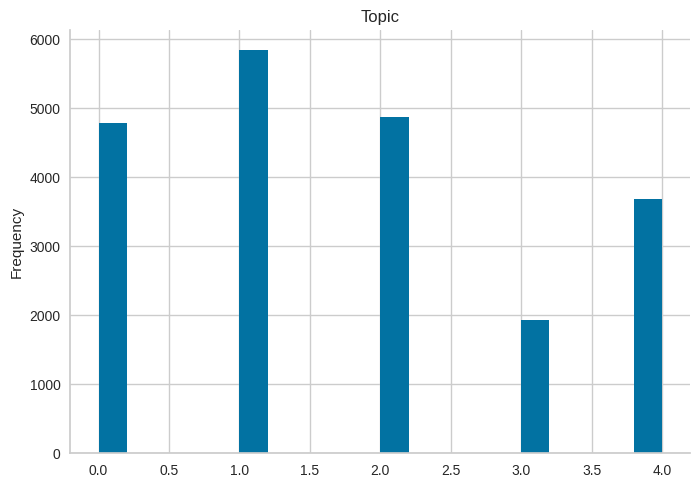

In [64]:
# @title Topic

from matplotlib import pyplot as plt
training_data['Topic'].plot(kind='hist', bins=20, title='Topic')
plt.gca().spines[['top', 'right',]].set_visible(False)

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [67]:
count_vectorizer = CountVectorizer(stop_words="english", min_df=10, max_df=0.80, ngram_range=(1,1))

#Write your code to get the Vector count
X_counts = count_vectorizer.fit_transform(training_data['complaint_what_happened'])

print(f"Dimensión de la matriz CountVectorizer: {X_counts.shape}")

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()

X_tfidf = tfidf_transformer.fit_transform(X_counts)

print(f"Dimensión de la matriz TF-IDF: {X_tfidf.shape}")

Dimensión de la matriz CountVectorizer: (21072, 6801)
Dimensión de la matriz TF-IDF: (21072, 6801)


In [68]:
X = X_tfidf
y = training_data['Topic']

X_df = pd.DataFrame(X.toarray(), index=training_data.index)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

print(f"Tamaño del Training: {X_train.shape}")
print(f"Tamaño del Test: {X_test.shape}")

Tamaño del Training: (16857, 6801)
Tamaño del Test: (4215, 6801)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [69]:
print("Nueva dimensión: ",X_tfidf.shape)
print("Nueva dimensión: ",training_data.shape)

Nueva dimensión:  (21072, 6801)
Nueva dimensión:  (21072, 2)


In [70]:
from pycaret.classification import *
# Write your code here to build any 3 models and evaluate them using the required metrics

setup(X_train, target = y_train, session_id = 42, fold=10)



,Description,Value
0,Session id,42
1,Target,Topic
2,Target type,Multiclass
3,Original data shape,"(16857, 6802)"
4,Transformed data shape,"(16857, 6802)"
5,Transformed train set shape,"(11799, 6802)"
6,Transformed test set shape,"(5058, 6802)"
7,Numeric features,6801
8,Preprocess,True
9,Imputation type,simple


In [71]:
best_model = compare_models(include=['lr', 'dt', 'rf', 'nb'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9469,0.0000,0.9469,0.9482,0.9465,0.9317,0.9321,25.3170
rf,Random Forest Classifier,0.8341,0.9792,0.8341,0.8458,0.8165,0.7843,0.7882,24.7030
dt,Decision Tree Classifier,0.7587,0.8447,0.7587,0.7596,0.7586,0.6908,0.6910,14.3280
nb,Naive Bayes,0.3833,0.6253,0.3833,0.4386,0.3946,0.2345,0.2404,6.0580


Processing:   0%|          | 0/21 [00:00<?, ?it/s]

In [72]:
prediction = predict_model(best_model, data=X_test)
prediction

,0,1,2,3,4,5,6,7,8,9,...,6793,6794,6795,6796,6797,6798,6799,6800,prediction_label,prediction_score
10796,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.5106
16441,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.9967
16623,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.9859
12833,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.7804
14844,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.8582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.8447
16266,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,0.9050
12363,0.0,0.0,0.0,0.0,0.000000,0.0,0.078555,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.5441
7476,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.9860


In [73]:
from sklearn.metrics import accuracy_score, classification_report
# Evaluate
print("Accuracy:", accuracy_score(y_test, prediction["prediction_label"]))
print("Classification Report:")
print(classification_report(y_test, prediction["prediction_label"]))

Accuracy: 0.9520759193357058
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       948
           1       0.95      0.96      0.95      1195
           2       0.95      0.96      0.96       928
           3       0.99      0.87      0.93       387
           4       0.96      0.94      0.95       757

    accuracy                           0.95      4215
   macro avg       0.96      0.94      0.95      4215
weighted avg       0.95      0.95      0.95      4215



In [74]:
final_model = finalize_model(best_model)

In [75]:
save_model(final_model, 'best_classification_model')
loaded_model = load_model('best_classification_model')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


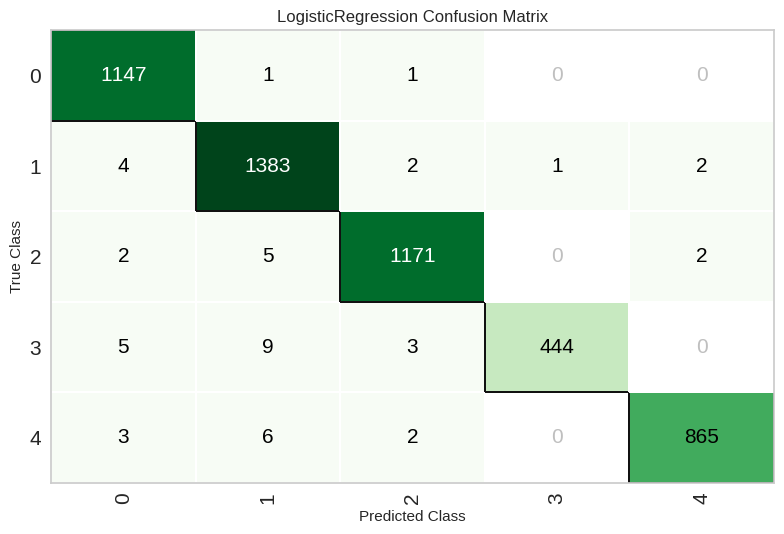

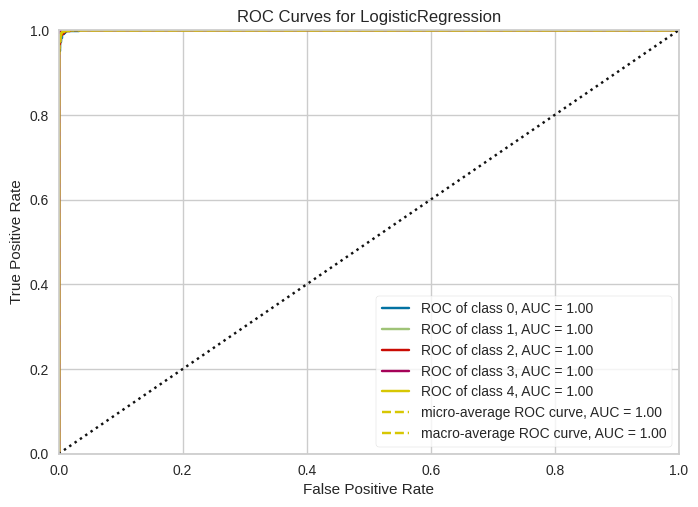

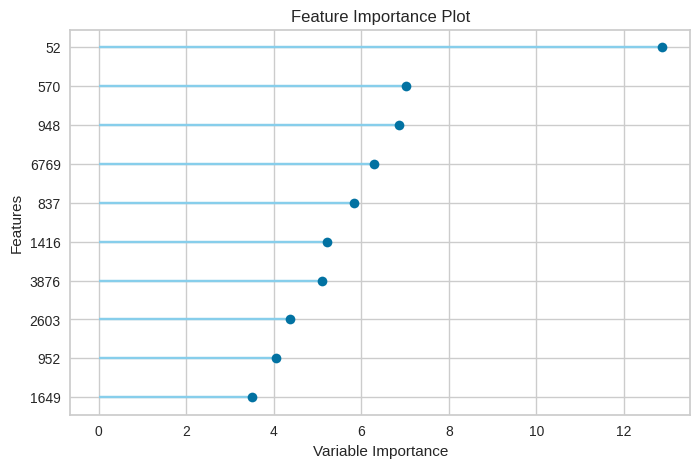

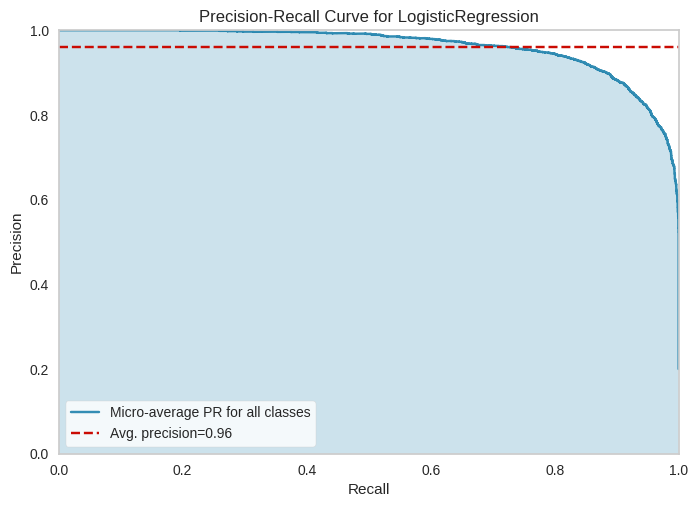

In [76]:
# Confusion Matrix
plot_model(final_model, plot='confusion_matrix')

# ROC Curve
plot_model(final_model, plot='auc')

# Feature Importance
plot_model(final_model, plot='feature')

# Precision-Recall Curve
plot_model(final_model, plot='pr')

# **Model Inference**

In [77]:
new_data = pd.DataFrame({
    'complaint': [
        "My credit card was cut, and I need to report it.",
        "I cannot access my bank account online and need immediate assistance.",
        "The mortgage payments have been miscalculated, and I need a correction."
    ]
})

# Preprocess the new data
new_data['cleaned_complaint'] = new_data['complaint'].apply(preprocess_text)


In [78]:
# Transform the new data using the saved vectorizer
new_data_tfidf = vectorizer.transform(new_data['cleaned_complaint'])


In [79]:
# Predict topics

new_data['predicted_topic'] = best_model.predict(new_data_tfidf)

# View the results
print(new_data[['complaint', 'predicted_topic']])

                                           complaint  predicted_topic
0   My credit card was cut, and I need to report it.                4
1  I cannot access my bank account online and nee...                0
2  The mortgage payments have been miscalculated,...                2
